In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [11]:
# Scale train/ test predictors based on training data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Create train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=  y_train)

In [13]:
# Scale train/ test predictors based on training data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Create train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=  y_train)
     

In [15]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [16]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

y_val_array = np.array(y_val)
val_set = np.c_[X_val, y_val_array]


# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

X_val, y_val = split_sequences(val_set, 25)
print(X_val.shape, y_val.shape)

(4111, 25, 561) (4111,)
(2923, 25, 561) (2923,)
(1355, 25, 561) (1355,)


In [17]:
print(X_train.shape, y_train.shape)

(4111, 25, 561) (4111,)


In [32]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

y_val = to_categorical(y_val)
print(y_val.shape)

(4111, 7)
(2923, 7)
(1355, 7)


In [33]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

In [34]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 23, 64)            107776    
                                                                 
 flatten_4 (Flatten)         (None, 1472)              0         
                                                                 
 dense_7 (Dense)             (None, 128)               188544    
                                                                 
 dense_8 (Dense)             (None, 7)                 903       
                                                                 
Total params: 297,223
Trainable params: 297,223
Non-trainable params: 0
_________________________________________________________________


In [35]:
# validation_split = 0.1
train_epochs = 10
history = model.fit(X_train, y_train, epochs=train_epochs, verbose=True,  validation_data = (X_val, y_val))

Epoch 1/10
129/129 [==============================] - 2s 11ms/step - loss: 1.2744 - accuracy: 0.4335 - val_loss: 0.7902 - val_accuracy: 0.6421
Epoch 2/10
129/129 [==============================] - 1s 11ms/step - loss: 0.4627 - accuracy: 0.8110 - val_loss: 0.4063 - val_accuracy: 0.8399
Epoch 3/10
129/129 [==============================] - 1s 11ms/step - loss: 0.2241 - accuracy: 0.9173 - val_loss: 0.3205 - val_accuracy: 0.8613
Epoch 4/10
129/129 [==============================] - 1s 10ms/step - loss: 0.1085 - accuracy: 0.9621 - val_loss: 0.2932 - val_accuracy: 0.8849
Epoch 5/10
129/129 [==============================] - 1s 10ms/step - loss: 0.0605 - accuracy: 0.9827 - val_loss: 0.2621 - val_accuracy: 0.8893
Epoch 6/10
129/129 [==============================] - 1s 9ms/step - loss: 0.0746 - accuracy: 0.9754 - val_loss: 0.2259 - val_accuracy: 0.9129
Epoch 7/10
129/129 [==============================] - 1s 9ms/step - loss: 0.0195 - accuracy: 0.9961 - val_loss: 0.2364 - val_accuracy: 0.9188
E

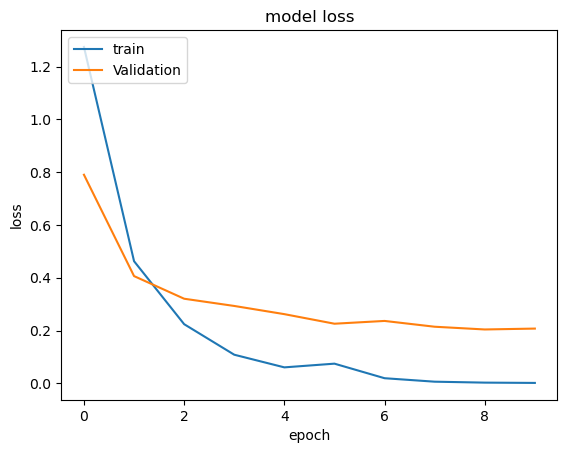

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

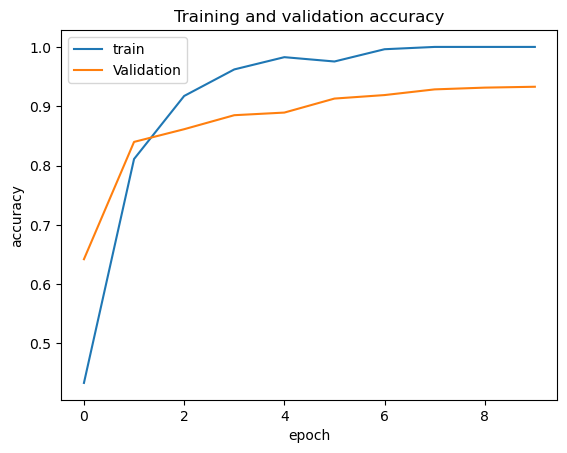

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')